In [8]:
!python -V

Python 3.12.9


In [14]:
!which python

/home/codespace/miniconda3/bin/python


In [15]:
!pwd


/workspaces/mlops_zoomcamp/02_experiment-tracking


In [16]:
!pip install -r requirements.txt

  Using cached mlflow-2.22.0-py3-none-any.whl.metadata (30 kB)
  Using cached jupyter-1.1.1-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached hyperopt-0.2.7-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached xgboost-3.0.1-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
  Using cached mlflow_skinny-2.22.0-py3-none-any.whl.metadata (31 kB)
  Using cached flask-3.1.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached alembic-1.16.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached docker-7.1.0-py3-none-any.whl.metadata (3.8 kB)
  Using cached graphene-3.4.3-py2.py3-none-any.whl.metadata (6.9 kB)
  Using cached gunicorn-23.0.0-py3-none-any.whl.metadata (4.4 kB)
  Using cached markdown-3.8-py3-none-any.whl.metadata (5.1 kB)
  Using cached pyarrow-19.0.1-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
  Using cached sqlalchemy-2.0.41-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.6 kB)
  Using cached cachetools-5.5.2-py3-none-any.whl.metadata (5.4 k

In [17]:
import pandas as pd

In [18]:
import pickle

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [21]:
# estas líneas son las que se agregan y se deben agregar a la tarea

import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("trip_duration_experiment")



2025/05/24 16:37:06 INFO mlflow.tracking.fluent: Experiment with name 'trip_duration_experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='/workspaces/mlops_zoomcamp/02_experiment-tracking/mlruns/1', creation_time=1748104626754, experiment_id='1', last_update_time=1748104626754, lifecycle_stage='active', name='trip_duration_experiment', tags={}>

In [22]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [23]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.838799799829628

/tmp/ipykernel_13003/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_13003/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


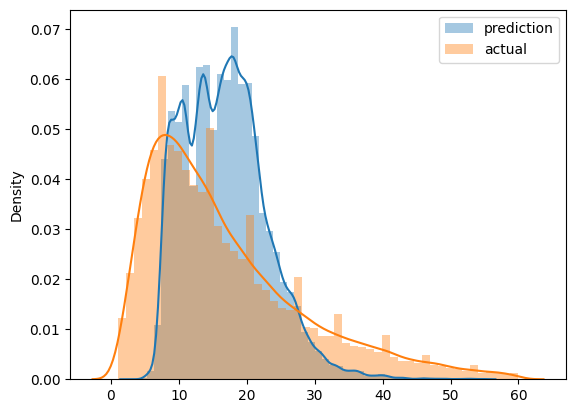

In [24]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [25]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [26]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [27]:
len(df_train), len(df_val)

(73908, 61921)

In [28]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [29]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [30]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [31]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715200888857

In [32]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [33]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

11.167275941179728

In [34]:
# estas otras lineas también van a la tarea

with mlflow.start_run():  # se abre un apartado que equivale a un experimento

    mlflow.set_tag("developer", "pepe")

    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.parquet")

    alpha = 0.01

    mlflow.log_param("alpha", alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)